**Differential methylation analysis**

In [ ]:
#dependencies
library(remotes)
library(methyLImp)
library(stringr)
library(Biostrings)
library(XVector)
library(bumphunter)
library(foreach)
library(iterators)
library(parallel)
library(locfit)
library(minfi)
library(readxl)
library(GenomicRanges)
library(rtracklayer)

In [9]:
# Data loading
bedfile <- read.table("sen3.bed", header = TRUE)  # Path to selected scenario (e.g., Scenario3)
gname1 <- "above6"  # sen1to3: above6, sen4&5: Ascending, sen6: discharged, sen7&8: abnormal
gname2 <- "below6"  # sen1to3: below6, sen4&5: Descending, sen6: deceased, sen7&8: normal

# Defining healthy samples file paths in severe vs mild/healthy analysis
healthy_files <- c("path to/SWIFTHLY1PE", 
                   "path to/SWIFTHLY2PE", 
                   "path to/SWIFTHLY3PE", 
                   "path to/SWIFTHLY4PE")
healthy_colnames <- paste0("belowH", 1:4)

read_and_rename <- function(file, new_colname) {
  df <- read.table(file, header = TRUE)
  colnames(df) <- c("chr", "st", "end", new_colname)
  return(df)
}
healthy_list <- mapply(read_and_rename, healthy_files, healthy_colnames, SIMPLIFY = FALSE)
for (healthy_df in healthy_list) {
  bedfile <- merge(bedfile, healthy_df, by = c("chr", "st", "end"), all.x = TRUE)
}
head(bedfile)


,chr,st,end,above6,above6.1,above6.2,above6.3,above6.4,above6.5,above6.6,⋯,below6.22,below6.23,below6.24,below6.25,below6.26,below6.27,belowH1,belowH2,belowH3,belowH4
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1,836950,837233,80.00000,57.57576,100.00000,100.00000,79.48718,100.00000,87.50000,⋯,100.00000,92.85714,75.00000,90.00000,98.21429,85.71429,NA,NA,NA,NA
2,chr1,850702,851077,83.33333,76.08696,66.66667,50.00000,90.00000,NA,100.00000,⋯,100.00000,83.33333,61.53846,94.44444,87.50000,75.00000,100.00000,84.72222,86.80556,81.94444
3,chr1,920168,920354,80.00000,50.00000,57.14286,85.71429,85.71429,100.00000,80.00000,⋯,56.41026,87.50000,0.00000,80.00000,85.18519,66.66667,69.69697,87.50000,93.05556,50.00000
4,chr1,986518,986840,90.00000,90.00000,NA,100.00000,100.00000,NA,88.88889,⋯,NA,100.00000,NA,72.72727,100.00000,100.00000,94.11765,100.00000,100.00000,100.00000
5,chr1,996096,996295,33.33333,57.14286,100.00000,50.00000,72.72727,50.00000,31.57895,⋯,83.33333,40.00000,100.00000,53.57143,59.09091,57.14286,50.00000,25.00000,73.18841,35.71429
6,chr1,1045135,1045787,56.52174,63.15789,50.00000,87.50000,83.33333,46.15385,83.33333,⋯,71.66667,95.23810,55.26316,61.84211,60.63063,93.33333,52.17391,85.22727,71.35417,80.00000


**Data Imputation**

In [ ]:

#methyLImp NA imputing 
g1=bedfile[,str_detect(colnames(bedfile),gname1)]   #grouping samples
g2=bedfile[,str_detect(colnames(bedfile),gname2)]   #grouping samples
rbed<-cbind(rownames(bedfile),bedfile)
colnames(rbed)[1]<-"DMRnumber"

num_NAs_g1 <- apply(g1, 1, function(row) sum(is.na(row)))
num_NAs_g2 <- apply(g2, 1, function(row) sum(is.na(row)))
# Identify rows with too many NAs in g1
rows_to_remove_g1 <- which(num_NAs_g1 > 0.20 * ncol(g1))
# Identify rows with too many NAs in g2
rows_to_remove_g2 <- which(num_NAs_g2 > 0.20 * ncol(g2))

bed.imp1 <- methyLImp(t(g1),min=0,max=100)
bed.imp2 <- methyLImp(t(g2),min=0,max=100)
bed.imp <-cbind(t(bed.imp1),t(bed.imp2))
bed.imp.c <- cbind(rbed[,1:4],bed.imp)   # adding chr number and start & end to imputed data

NAdelbed<-bed.imp.c[-c(rows_to_remove_g1,rows_to_remove_g2),]
dim(NAdelbed)                 
#write.table(NAdelbed,"path/senx.txt",sep=" ",row.names=F)  

** DMR finding**

In [ ]:
gp1=grepl( gname1 ,colnames(NAdelbed))
gp2=grepl( gname2 ,colnames(NAdelbed))
a= sum(gp1)   #group1_col_number
b= sum(gp2)    #group2_col_number
beta <- as.matrix(NAdelbed[, -c(1:4)])  
head(beta)
group <- c(rep(1,a),rep(2,b))  

############################################    minfi
####minfi required packages loaded
beta_values<- beta/100
hist(beta_values)
# Convert the beta values into M-values
M_values <- log2((beta_values + 0.01) / (1 - beta_values + 0.01))
hist(M_values)
sample_groups <- c(rep(gname1,a), rep(gname2,b))
head(sample_groups)
dmp_results <- dmpFinder(M_values, pheno = sample_groups)
sig_pval<- dmp_results[dmp_results$p < 0.05, ]
sig_qval<- dmp_results[dmp_results$q < 0.05, ]
print("dimention of siqnificant p values")
dim(sig_pval)
print("dimention of siqnificant q values")
dim(sig_qval)

## saving sig pval
ven_p<- dmp_results[dmp_results$p < 0.05, ]
R2<-rownames(ven_p[,])
resp3<-cbind(rbed[R2,1:4],ven_p)
#write.table(resp3, file="resp3.txt", sep="\t", row.names=FALSE)


In [38]:
head(resq3)

,DMRnumber,chr,st,end,intercept,f,pval,qval
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
5515,5515,chr17,63409972,63410243,2.5889819,23.43755,1.283072e-05,0.07497569
5635,5635,chr17,74324852,74325036,-1.8716201,23.31852,1.338256e-05,0.07497569
5153,5153,chr17,5170246,5170469,-0.4209801,21.44440,2.623819e-05,0.08291916
7434,7434,chr2,70205650,70205858,-1.7306388,21.11444,2.960081e-05,0.08291916
12949,12949,chr9,97682557,97683178,3.0508403,19.96124,4.534294e-05,0.10161340
7869,7869,chr2,233247353,233247515,3.2590918,18.43981,8.058536e-05,0.15049298


** tissue Specific DMR Investigation**

In [39]:

top1000 <- read_excel("atlas/top1000.xlsx", sheet = 1) 
scen_number<-resq3
gr1 <- GRanges(seqnames = scen_number$chr,
               ranges = IRanges(start = scen_number$st, end = scen_number$end),
               beta = scen_number$qval)
atlas<-top1000
gr2 <- GRanges(seqnames = atlas$chr,
               ranges = IRanges(start = atlas$start, end = atlas$end),
               beta = atlas$Diff) 
overlaps <- findOverlaps(gr1, gr2)
common_regions <- pintersect(gr1[queryHits(overlaps)], gr2[subjectHits(overlaps)])
overlap_indices <- subjectHits(overlaps)
overlapping_rows <- top1000[overlap_indices, ]
head(data.frame(overlapping_rows))


New names:
• `` -> `...15`


,Type,chr,start,end,startCpG,endCpG,position,Number.of.CpGs,Length,Target.meth.,Background.meth.,Diff,Genomic.class,Gene,...15,p.value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>
1,Blood-Granul,chr17,74324646,74325212,23170589,23170603,chr17:74324646-74325212,14CpGs,566bp,0.3650,0.942,0.5770,intron,PRPSAP1,NA,NA
2,Pancreas-Acinar,chr10,116190310,116190874,15722673,15722678,chr10:116190310-116190874,5CpGs,564bp,0.0421,0.882,0.8399,TTS,ABLIM1,NA,NA
3,Pancreas-Delta,chr20,20420912,20421185,25265507,25265512,chr20:20420912-20421185,5CpGs,273bp,0.1420,0.822,0.6800,intron,RALGAPA2,NA,NA
4,Pancreas-Acinar,chr1,155167099,155167572,1433009,1433022,chr1:155167099-155167572,13CpGs,473bp,0.0998,0.910,0.8102,exon,THBS3,NA,NA
5,Skeletal-Musc,chr8,139735754,139735883,13272296,13272301,chr8:139735754-139735883,5CpGs,129bp,0.3690,0.806,0.4370,intron,COL22A1,NA,NA
6,Heart-Cardio,chr5,1946637,1946709,7597414,7597419,chr5:1946637-1946709,5CpGs,72bp,0.0604,0.824,0.7636,Intergenic,IRX4,NA,NA


In [40]:
# Getting overlaps and intersected regions
overlaps <- findOverlaps(gr1, gr2)
# Extracting intersected regions
common_regions <- pintersect(gr1[queryHits(overlaps)], gr2[subjectHits(overlaps)])
# Adding metadata from gr1 and gr2
common_metadata <- cbind(
  as.data.frame(gr1[queryHits(overlaps)]),  # Metadata from gr1
  as.data.frame(gr2[subjectHits(overlaps)]) # Metadata from gr2
)
head(common_metadata)

,seqnames,start,end,width,strand,beta,seqnames,start,end,width,strand,beta
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<dbl>
1,chr17,74324852,74325036,185,*,0.07497569,chr17,74324646,74325212,567,*,0.5770
2,chr10,116190791,116191091,301,*,0.26255766,chr10,116190310,116190874,565,*,0.8399
3,chr20,20421132,20421486,355,*,0.26255766,chr20,20420912,20421185,274,*,0.6800
4,chr1,155167066,155167570,505,*,0.26255766,chr1,155167099,155167572,474,*,0.8102
5,chr8,139735778,139736078,301,*,0.27563778,chr8,139735754,139735883,130,*,0.4370
6,chr5,1946409,1946893,485,*,0.27626286,chr5,1946637,1946709,73,*,0.7636


In [42]:
#Integrating different cell type from each tissue
cell_types <- c(
  "Adipocytes", "Bladder-Ep", "Blood-B", "Blood-Granul", "Blood-Mono+Macro", "Blood-NK", "Blood-T",
  "Bone-Osteob", "Breast-Basal-Ep", "Breast-Basal-Ep:Breast-Luminal-Ep", "Breast-Luminal-Ep",
  "Colon-Ep", "Colon-Ep:Gastric-Ep:Small-Int-Ep", "Colon-Ep:Small-Int-Ep", "Colon-Fibro",
  "Colon-Fibro:Heart-Fibro", "Dermal-Fibro", "Endothel", "Epid-Kerat", "Eryth-prog", "Fallopian-Ep",
  "Fallopian-Ep:Ovary-Ep", "Gallbladder", "Gastric-Ep", "Gastric-Ep:Small-Int-Ep", "Head-Neck-Ep",
  "Heart-Cardio", "Heart-Cardio:Heart-Fibro", "Heart-Cardio:Skeletal-Musc:Smooth-Musc", "Heart-Fibro",
  "Kidney-Ep", "Liver-Hep", "Lung-Ep-Alveo", "Lung-Ep-Alveo:Lung-Ep-Bron", "Lung-Ep-Bron", "Neuron",
  "Neuron:Oligodend", "Oligodend", "Ovary-Ep", "Pancreas-Acinar", "Pancreas-Alpha",
  "Pancreas-Alpha:Pancreas-Beta:Pancreas-Delta", "Pancreas-Beta", "Pancreas-Delta", "Pancreas-Duct",
  "Prostate-Ep", "Skeletal-Musc", "Skeletal-Musc:Smooth-Musc", "Small-Int-Ep", "Smooth-Musc",
  "Thyroid-Ep")
overlapping_rows$Organ <- sub("-.*", "", overlapping_rows$Type)
head(overlapping_rows)
dim(overlapping_rows)                          

Type,chr,start,end,startCpG,endCpG,position,Number of CpGs,Length,Target meth.,Background meth.,Diff,Genomic class,Gene,...15,p-value,Organ
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<dbl>,<chr>
Blood-Granul,chr17,74324646,74325212,23170589,23170603,chr17:74324646-74325212,14CpGs,566bp,0.3650,0.942,0.5770,intron,PRPSAP1,NA,NA,Blood
Pancreas-Acinar,chr10,116190310,116190874,15722673,15722678,chr10:116190310-116190874,5CpGs,564bp,0.0421,0.882,0.8399,TTS,ABLIM1,NA,NA,Pancreas
Pancreas-Delta,chr20,20420912,20421185,25265507,25265512,chr20:20420912-20421185,5CpGs,273bp,0.1420,0.822,0.6800,intron,RALGAPA2,NA,NA,Pancreas
Pancreas-Acinar,chr1,155167099,155167572,1433009,1433022,chr1:155167099-155167572,13CpGs,473bp,0.0998,0.910,0.8102,exon,THBS3,NA,NA,Pancreas
Skeletal-Musc,chr8,139735754,139735883,13272296,13272301,chr8:139735754-139735883,5CpGs,129bp,0.3690,0.806,0.4370,intron,COL22A1,NA,NA,Skeletal
Heart-Cardio,chr5,1946637,1946709,7597414,7597419,chr5:1946637-1946709,5CpGs,72bp,0.0604,0.824,0.7636,Intergenic,IRX4,NA,NA,Heart


[1] 12 17

** visualisation**

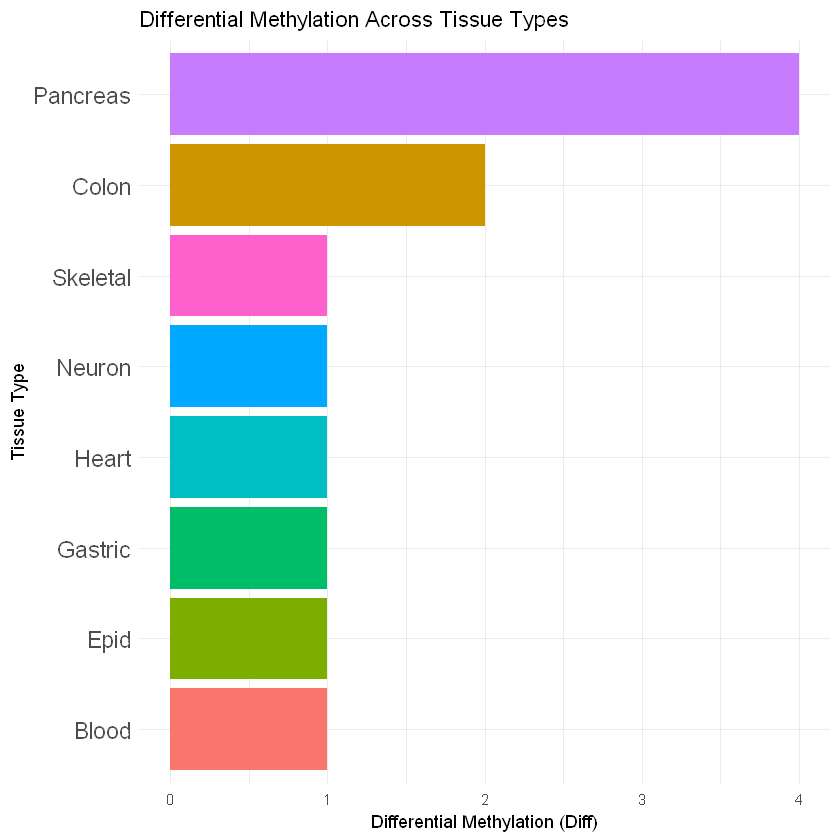

In [44]:
library(ggplot2)
organ_counts <- table(overlapping_rows$Organ)
organ_counts_df <- as.data.frame(organ_counts)
colnames(organ_counts_df) <- c("Organ", "Count")
# Bar plot
ggplot(organ_counts_df, aes(x = reorder(Organ, Count), y = Count, fill = Organ)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  coord_flip() + 
  labs(
    title = "Differential Methylation Across Tissue Types",
    x = "Tissue Type",
    y = "Differential Methylation (Diff)"
  ) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 14))  
